# Setup

In [1]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np
import h5py
import copy
import random
import pandas as pd
import keras_tuner as kt
import pandas as pd
from scipy import stats
from numba import cuda
from sklearn.model_selection import train_test_split as _train_test_split

import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow_probability import distributions
from tensorflow_probability import math
from tensorflow_probability import distributions
from tensorflow_probability import math as tfpmath

# workaround to import pdn and CLR from another forlder while they are not installed
import sys
sys.path.insert(0,'../ML_tracer_painting/')
sys.path.insert(0,'./')

#import pdn
import clr_callback as CLR

tf.config.optimizer.set_jit(True)  #setting the XLA (Accelerated Linear Algebra) flag 

# # Check if a GPU is available
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# # Ensure TensorFlow is configured to use the GPU
# assert tf.test.is_gpu_available(), "No GPU detected or TensorFlow is not configured to use it."


2023-12-01 07:59:17.790217: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-01 07:59:17.830701: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-01 07:59:17.830728: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-01 07:59:17.830737: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-01 07:59:17.838119: I tensorflow/core/platform/cpu_feature_g

In [2]:
%matplotlib inline

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif"
})

In [3]:
directory_path = "/home/ubuntu/Thesis/quijote/" # add path to the data directory

## Loading the Data
We are considering $k_{max} = 0.2$ "mildly linear" case. The data "df" contains the normalized parameters and summary statistics in one single data frame. The data "df_lbl" contains the normalised parameters. The summary statistics used here are power spectrum (P0_0 - P0_31),
marked power spectrum(MP0, MP01, MP02, MP04 each with 32 entries eg. MP0_0 - MP0_31), bispectrum(B_0 - B_72),marked bispectrum(MB, MB1, MB2, MB4 each with 67 entries from MB_0 -MB_66) and halo mass function(HMF_0-HMF_11). The labels contains the parameters $f_{NL}^{eq}$,$\Omega_m$,$h$,$n_s$,$\sigma_8$

In [4]:
# # Reading the data

# pk = pd.read_csv(directory_path+"Pk_lh.csv")[:80].T                      # taking transpose to keep in check the dimensionality
# pk.reset_index(drop = True,inplace=True)                            # dropiing index for concatenating the P_k data with the parameters 
# params = pd.read_csv(directory_path+"lh_params.csv",index_col= 0)   # laoding the vanilla parameters data

# #normalising the parameters
# mean_params = params.mean(axis=0).values
# std_params = params.std(axis = 0).values
# norm_params = (params - mean_params)/std_params

# # Concatenating the params and pk

#df = pd.concat([norm_params,pk],axis = 1)


# P_k = df[df.columns[5:]]
# van_labels = df[df.columns[:5]]


## Reading the Data
df_all = pd.read_csv(directory_path + "data_lh.csv")

## Unnormalised parameters
df_lbl = pd.read_csv(directory_path + "unnormalised_lbl.csv")
mean_params = df_lbl.mean(axis=0).values # mean of params
std_params = df_lbl.std(axis = 0).values # standard deviation of params

df_all


,fnl_equil,Om,h,ns,s8,P0_0,P0_1,P0_2,P0_3,P0_4,...,HMF_2,HMF_3,HMF_4,HMF_5,HMF_6,HMF_7,HMF_8,HMF_9,HMF_10,HMF_11
0,0.579947,0.285646,-0.895023,0.628420,-0.770378,7.694324e+04,72699.988971,80060.577932,66006.190973,60844.371143,...,16901,9873,5786,3040,1506,618,221,67,11,3
1,-0.219861,-0.161000,-0.822313,-1.296658,1.237798,1.784552e+05,217724.754529,170829.183345,122275.653483,111882.779876,...,15712,10474,6948,4290,2654,1600,882,450,163,71
2,-1.185862,-1.317432,-0.901948,0.725367,-1.570185,1.272849e+06,877065.512870,691072.249241,417614.884669,360848.651773,...,2035,1041,499,215,70,23,9,0,0,0
3,-0.545323,0.302957,1.327819,-1.687906,1.248185,4.066970e+04,72895.619417,78330.482070,70627.845993,64061.072840,...,22477,14804,9930,6219,3777,2095,1088,509,209,58
4,1.660207,1.680981,-1.109690,1.680981,0.077903,1.245194e+04,18920.361863,22937.191376,27123.116865,24749.233084,...,39873,26164,16630,9836,5274,2730,1176,408,133,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-1.632508,-1.435153,0.818851,0.929647,0.870786,6.906393e+05,477106.546386,407935.986024,252411.271003,168527.313031,...,6247,3820,2194,1260,671,306,139,48,15,4
996,-1.590959,0.320269,-1.667132,0.199086,-1.428228,9.062285e+04,118855.924989,115250.670403,107756.660844,90393.284458,...,11838,6488,3456,1692,786,248,81,14,5,0
997,0.694205,0.940034,-0.264871,0.271796,-0.323732,2.706000e+04,35874.495733,42646.730659,42935.895217,38941.706934,...,26815,16834,10118,5692,3005,1414,569,191,50,12
998,0.507237,-0.635345,-1.206636,0.424140,-1.403991,3.310482e+05,330489.896973,242223.693255,216801.822755,162986.136645,...,6081,3249,1739,788,353,136,43,8,2,0


#### Creating different datasets for different summary statistics.

In [5]:
# PARMAETERS AND SUMMARY STATISTICS 
"""
sliced the main dataset into different statistics
"""
norm_lbl = df_all.loc[:,'fnl_equil':'s8']
P0  = df_all.loc[:,'P0_0':'P0_31']
MP0 = df_all.loc[:,'MP01_0':'MP04_31']
B0  = df_all.loc[:,'B_0':'B_72']
MB  = df_all.loc[:,'MB1_0':'MB4_66']
HMF = df_all.loc[:,'HMF_0':'HMF_11']


In [6]:
# Function to create input data fot combination of summary statistics

def input_data(columns,norm_lbl):
    
    """
    columns: it takes a list input of the summary statistics
    norm_lb: it is the normalised label of the parameters
    selects the different summary statistics 
    to make it into a single dataframe, which 
    can then be used as the input in the NN.
    """
    
    assert isinstance(columns, list), "Input is not a list"
    df_columns = pd.concat(columns,axis =1)
    
    return pd.concat([norm_lbl,df_columns],axis=1)


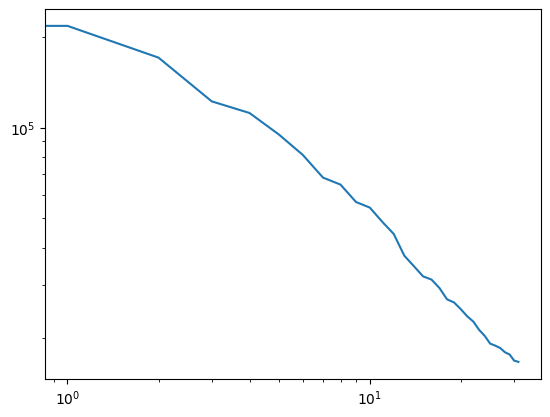

In [7]:
#Plotting the power spectrum
plt.plot(P0.T[1])             # Transposing to plot power spectrum for each simulation 
plt.loglog()
plt.show()


#### Data splitting into Train, Validation and Test set

In [8]:
def train_val_test_split(df,params = 5,random_state =1, train_frac = 0.6,test_frac = 0.2):
    
    """
    df: The input dataframe
    params: the number of params default set to 5. Change if adding more parameters
    train_frac: fraction of training data
    test_frac: fraction of test data
    """
    
    # Permuting the DataFrame to avoid any bias.
    
    df = df.sample(frac=1,random_state=random_state) 

    #seperating the input and labels in the df

    X = df[df.columns[params:]]
    y = df[df.columns[:params]]
    


    # Splitting into training, test and validation

    train_frac = train_frac
    test_frac =  test_frac
    val_frac = 1- (train_frac+test_frac)
    
#     assert train_frac + val_frac + test_frac == 1,"Fraction should add up to 1" # to ensure that the sum is one

    # defining the size for training, test and validation
    
    train_size, test_size, val_size = map(lambda frac: round(len(df) * frac), [train_frac, test_frac, val_frac])

    X_train, X_val, X_test, y_train, y_val, y_test = X[:train_size],X[train_size:train_size+test_size],X[train_size+test_size:],\
                                                     y[:train_size],y[train_size:train_size+test_size],y[train_size+test_size:]
    
    return(X_train, X_val, X_test, y_train, y_val, y_test)

# Define couple of useful functions

#### Defining the loss plot function

In [9]:
# Function defining loss plot.

def plot_loss(df_history, ylim=None, logy=False):
    plt.figure(figsize=(12,8 ))
    
    plt.plot(df_history.index, df_history['loss'], label='Training_loss')
    plt.plot(df_history.index, df_history['val_loss'], label='Validation_loss')

    
#     for key, history in histories.items():
#         plt.plot(
#             np.array(range(len(history.history['val_loss'])))-0.5, 
#             history.history['loss'], 
#             label='loss'
#         )
#         plt.plot(history.history['val_loss'], label='val_loss')

    if logy:
        plt.semilogy()
    if ylim is not None:
        plt.ylim(ylim[0], ylim[1])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
#     print(key)
    plt.title("Training and Validation Loss")
    plt.grid(True)
    plt.show()

#### LaTex Label Names

In [10]:
label_LaTeX_names_vanilla = [
    r"$\Omega_m$",
    r"$\Omega_b$",
    r"$h$",
    r"$n_s$",
    r"$\sigma_8$"
]

label_LaTeX_names_equilateral = [r"$f_{NL}^{eq}$", 
                                 r"$\Omega_m$",
                                 r"$h$",
                                 r"$n_s$",
                                 r"$\sigma_8$"]

#### Defining Elu+1 activation function
Used for positive definiteness of the Sigma outputs. ELU gives a negative output however for the sigma values we need a positive definiteness so ELU+1 helps with that

In [11]:
def elu_plus_one(input):

    """ Adds one to the Exponential Linear Unit

    """

    return tf.add(

       tf.nn.elu(input),

        tf.constant(1.0000001, dtype=tf.float32) # Notice I added 1.e-7 for stability

    )

tf.keras.utils.get_custom_objects().update({'elu_plus_one': layers.Activation(elu_plus_one)})

# Analysis

## Building the model
Creating layers and defining hyperparameter tuninig. Also defined ELU+1 activation funtion

In [12]:
def model_build(hp):

    
#############################   Hyper-tuning Parameters  #############################  
    num_layers = hp.Int('num_layers', min_value=1, max_value=5)
    
    architecture = [hp.Int(f"unit_num_{i}", min_value = 32,
                           max_value = 512, step = 32) for i in range(num_layers)]
    
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    
    
    
#############################   Creating Layers  #############################
    
    # The features are normalized to have mean=0 and std=1
    inputs = Input(shape= X_training_set.shape[1])
    normalize_layer = layers.Normalization()
    normalize_layer.adapt(X_training_set)
    norm_inputs = normalize_layer(inputs)
    input_layer = norm_inputs

    
    # Adding hidden dense layers which is specified by the architecture in our case it is 3 layers with 32 neurons each
  

    for n_nodes in architecture:
        d_layer = layers.Dense(n_nodes,
                              activation="selu",
                              kernel_initializer="he_normal",)(input_layer)

        
    # Each is followed by a dropout layer  to apply dropout regularisation to the o/p of the d_layer which is then assigned to the input_layer for the next iteration which is the two dense layer mean and sigma our output layers
        
        
        input_layer = layers.Dropout(dropout_rate)(d_layer)


    # Add the output layer combining means and sigmas
   
    
    means = layers.Dense(
        5,
        activation="linear",
        kernel_initializer="he_normal",
    )(input_layer)

    sigmas = layers.Dense(
        5, 
        activation="elu_plus_one", # ????is there any particular reason for using elu+1? - yes as it is an exponential function so doest return 0 for a negative function.
        kernel_initializer="he_normal",
    )(input_layer)

    output_layer = layers.Concatenate()([means, sigmas])


#############################   Creating Model  #############################
    
    
    model = Model(inputs=inputs, outputs=output_layer)
    
    
    model.compile(
        loss=mse_means_and_sigmas_uncorrelated,
        optimizer=tf.optimizers.Adam(learning_rate = learning_rate ),
        #optimizer=tf.optimizers.Adam(learning_rate=1.e-3),
    )
    # model.summary()
    
    return model

## Defining loss

In [13]:
def mse_means_and_sigmas_uncorrelated(y_true, y_pred):
    
    means_pred, sigmas_pred = tf.split(y_pred, num_or_size_splits=2, axis=1)
    
    y_true = tf.cast(y_true, dtype=y_pred.dtype) #????? 
    
    squared_differences = tf.math.square(y_true - means_pred)
    sigmas2_sigma = tf.math.reduce_mean(tf.math.square(squared_differences - tf.math.square(sigmas_pred)), 0)
    sigmas2 = tf.math.reduce_mean(squared_differences, 0) 

    loss = tf.math.reduce_mean(tf.math.log(sigmas2) + tf.math.log(sigmas2_sigma))
    #loss = tf.math.reduce_mean(sigmas2 + sigmas2_sigma)

    return loss

## Define callbacks

In [14]:
# Definfing callbacks using cyclic learning rate in our case
def callback():
    max_lr = 1.e-3
    clr_triangular = CLR.CyclicLR(#mode='exp_range',
                                  base_lr=max_lr/4.,
                                  max_lr=max_lr,
                                  step_size=3*4, # recommended (2-8) x (training iterations in epoch)
                                  gamma=0.99994)
    
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=100, #The number pavid people that want to do better than 10 but not commit to 100 use.
        restore_best_weights=True,
        verbose=0,
    )
    return [clr_triangular, early_stopping]

## Define some ancillary stuff

In [15]:
def check_predictions(trueY, predicY, predicE, label='quantity [some units]', numbins=100, title=None):
    fig, ax = plt.subplots(ncols=3,sharex=True,figsize=(9,2.8))#6.4,2.8 #6.4,4.8

    ax[0].errorbar(
        x=trueY[:], y=predicY,
        yerr=predicE,
        elinewidth=0.5,
        linewidth=0,
        #bins='log', xscale='log', yscale='log',
        #gridsize=numbins
    )
    extremes = [np.min([trueY, predicY]),np.max([trueY, predicY])]    
    ax[0].set_xlabel('True '+label)
    ax[0].set_ylabel('Predicted '+label)
    ax[0].plot(extremes, extremes, c='k')
    ax[0].set_xlim(extremes[0], extremes[1])
    ax[0].set_ylim(extremes[0], extremes[1])
    ax[0].set_aspect('equal', adjustable='box')
    
    ymean = np.mean(trueY)
    R2 = 1.-np.sum((trueY-predicY)**2) / np.sum((trueY-ymean)**2)
    
    ax[0].text(0.975, 0.025, r'$R^2$=%.2f'
               "\n"
               r"$\chi^2$=%.2f" %(R2, np.sum((trueY - predicY)**2/predicE**2)/(len(predicE)-2)),
               style='italic', transform=ax[0].transAxes,
        bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 2}, ha="right", va="bottom")
    
    ax[1].plot(trueY, predicE, marker=".", lw=0, markersize=2, alpha=1)
    ax[1].set_xlabel('True '+label)
    ax[1].set_ylabel('Standard deviation')
    ax[1].text(0.975, 0.025, r'$\langle\sigma \rangle$=%.2f'
               "\n"
               r"RMSE=%.2f" %(np.mean(predicE), np.sqrt(np.mean((predicY-trueY)**2))), 
               style='italic', transform=ax[1].transAxes,
               bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 2},
               ha="right", va="bottom")
    
    ax[2].grid(axis="y",alpha=0.5,ls="--")
    
    ax[2].plot(trueY, (predicY-trueY)/predicE, marker=".", lw=0, markersize=2, alpha=1)
    ax[2].set_xlabel('True '+label)
    ax[2].set_ylabel(r'Bias [$\sigma$]')
    ax[2].grid(axis="y",alpha=0.5,ls="--")
    ax[2].text(0.975, 0.025, r"$\langle bias \rangle$=%.2f"
               "\n"
               r"$\langle |bias| \rangle$=%.2f" % (np.mean((predicY-trueY)/predicE), np.mean(np.abs(predicY-trueY)/predicE)), 
               style='italic', transform=ax[2].transAxes,
               bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 2},
               ha="right", va="bottom")
    plt.tight_layout()
    
    if title is not None:
        plt.subplots_adjust(left=0.1, right=0.975, top=0.9, bottom=0.2)
        plt.suptitle(title)#, fontdict={'horizontalalignment': "center"})
    else:
        plt.subplots_adjust(left=0.05, right=0.975, top=0.975, bottom=0.2)
    fig.show()

In [16]:
# prediction of parameters
def prediction(model,X_test_set,y_test_set,mean_params,std_params,title):
    
    """
    model: model name of the fitting model
    X_test_set: Test set
    y_test_set: Test Label
    title: String i/p - summary statistics used
    """
    assert isinstance(title, str), "Title must be a string"
    predictions = model.predict(X_test_set, verbose=0)
    df_predictions = pd.DataFrame(predictions)
    y_mean_predict = df_predictions[df_predictions.columns[:5]]
    y_sigma_predict = df_predictions[df_predictions.columns[5:]]
    
    true_y = ((y_test * std_params) + mean_params).reset_index(drop=True).values
    predict_y = ((y_mean_predict * std_params)  + mean_params).values
    predict_E = (y_sigma_predict*std_params).values
    # print("Returns true_y, predict_y, predict_E, df_predictions")
    
    #Plot of Predicted, std_dev, Bias vs True 
    for j in range(len(mean_params)):
        check_predictions(
            true_y[:,j],
            predict_y[:,j],
            predict_E[:,j],
            label=label_LaTeX_names_equilateral[j],
            title= title)
    return (true_y,predict_y,predict_E,df_predictions)
    


In [17]:
# #Plot of Predicted, std_dev, Bias vs True 

# def param_plot(predictions,param_number = 5):
#     """
#     predictions: Calls the prediction function
#     """
#     for j in range(param_number):
#         check_predictions(
#             predictions[0][:,j],
#             predictions[1][:,j],
#             predictions[2][:,j],
#             label=label_LaTeX_names_equilateral[j],
#             title="P0")


# Tuning hyperparameters

### All summary statistic

In [17]:
#performing spitting
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(df_all)

In [18]:
X_training_set = X_train

# Instantiating the tuner
tuner = kt.BayesianOptimization(
    model_build,
    objective= 'val_loss',
    max_trials = 30,
    directory='keras_tuner_dir',
    project_name='bayesian_optimisation')
# Running the HyperParameter Search

tuner.search(X_train, y_train, validation_data=(X_val, y_val), epochs=100000, callbacks=callback())





Reloading Tuner from keras_tuner_dir/bayesian_optimisation/tuner0.json


#### Let us see the best hypertune parameters

In [19]:
print(tuner.search_space_summary())
print(tuner.results_summary())


Search space summary
Default search space size: 8
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
unit_num_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
dropout_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
unit_num_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
unit_num_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
unit_num_3 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
unit_num_4 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'samplin

In [20]:
best_hp=tuner.get_best_hyperparameters(num_trials=1)[0]

best_num_layers = best_hp.get('num_layers')
best_architecture = [best_hp.get(f"unit_num_{i}") for i in range(best_num_layers)]
best_learning_rate = best_hp.get('learning_rate')
best_dropout_rate = best_hp.get('dropout_rate')

print(f"""
Best Hyperparameters:
- Number of Layers: {best_num_layers}
- Architecture: {best_architecture}
- Learning Rate: {best_learning_rate}
- Dropout Rate: {best_dropout_rate}
""")



Best Hyperparameters:
- Number of Layers: 2
- Architecture: [256, 256]
- Learning Rate: 0.001
- Dropout Rate: 0.1



In [21]:
# Fitting the model
model = model_build(best_hp)
histories= model.fit(
    X_train,
    y_train,
    validation_data=(X_val,
                     y_val),
    batch_size=512,
    epochs=1000000,
    callbacks=callback(),
    verbose=0,
)
# Histories return 
df_history = pd.DataFrame(histories.history)
df_history

2023-12-01 07:59:58.332575: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-01 07:59:58.368670: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-01 07:59:58.368899: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

,loss,val_loss
0,6.846954,2.959510
1,4.702741,2.148013
2,6.865073,1.200490
3,4.928632,1.125676
4,6.205232,1.764348
...,...,...
1332,-5.383033,-5.302296
1333,-5.389181,-5.327186
1334,-5.432152,-5.381891
1335,-5.532166,-5.237747


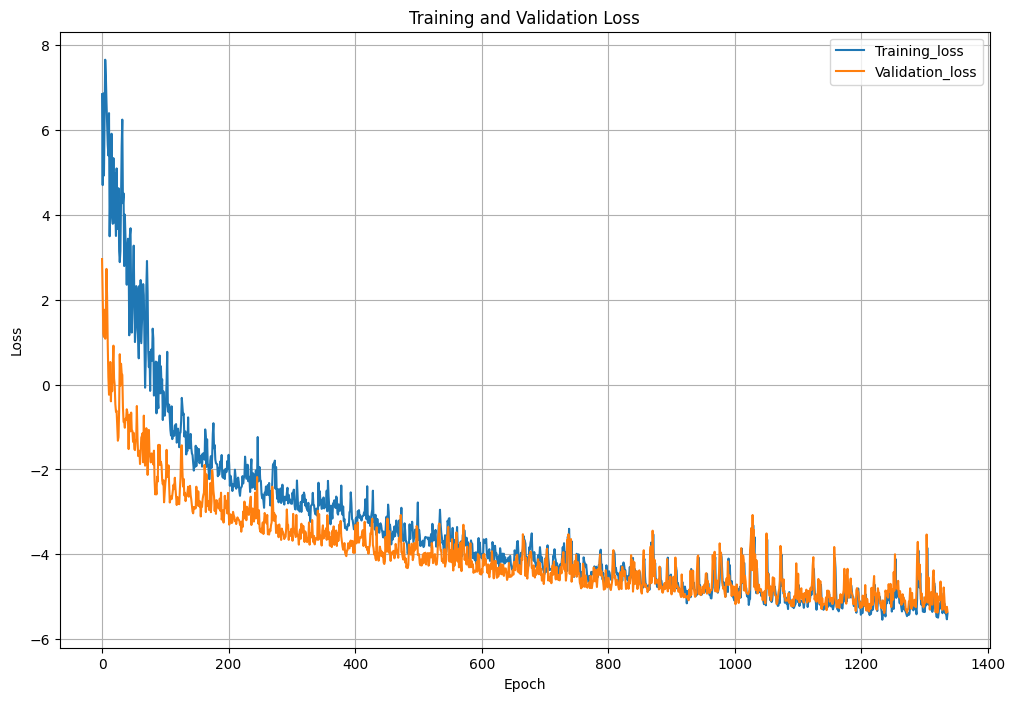

In [22]:
plot_loss(df_history)#, logy=True, ylim=[15, 25])

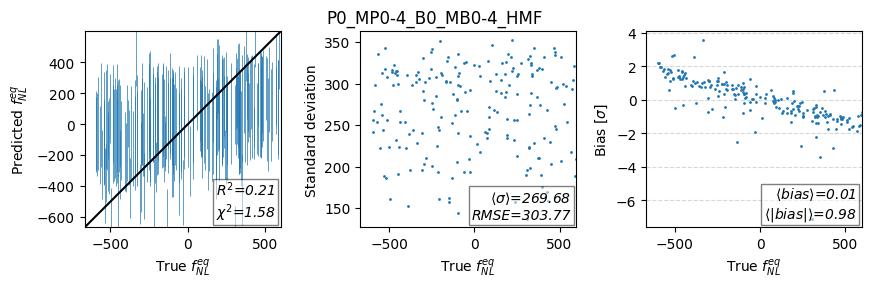

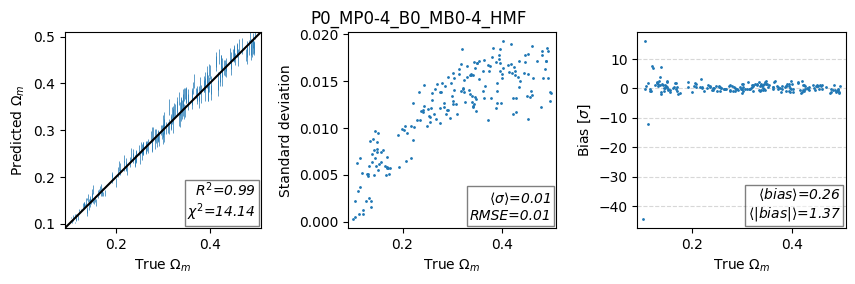

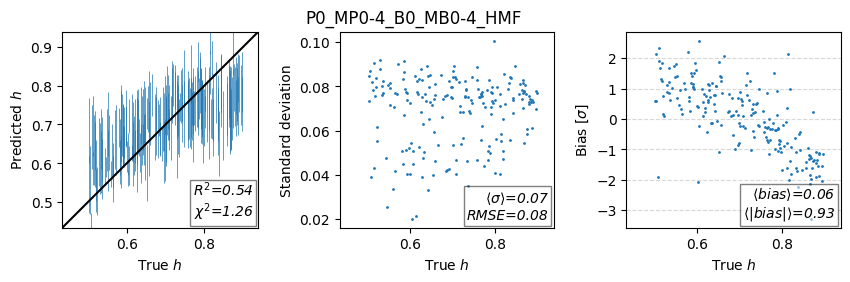

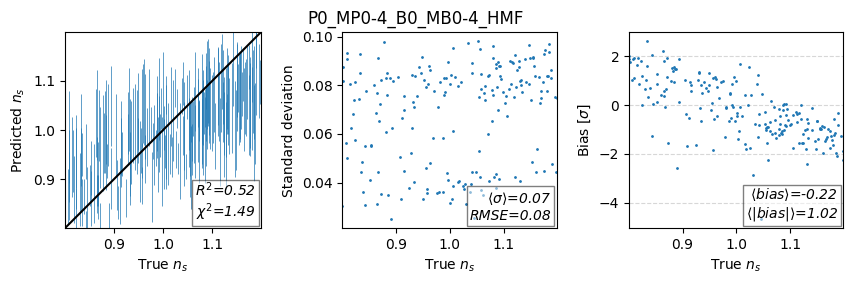

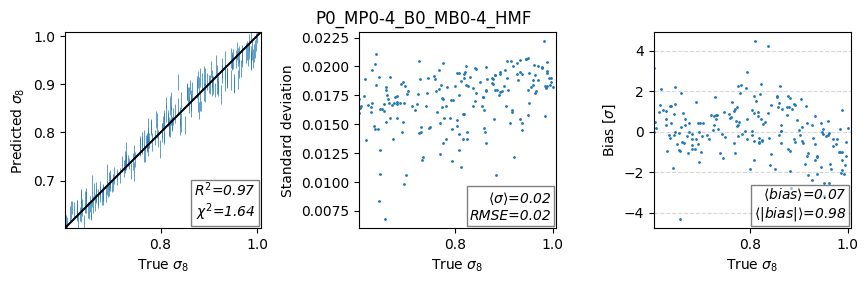

In [23]:
predictions = prediction(model,X_test,y_test,mean_params,std_params,title = "P0_MP0-4_B0_MB0-4_HMF")


#### Let us try a different set of summary statistics 

In [24]:
# Call the Data
columns = [P0, B0, HMF]
df_1 = input_data(columns,norm_lbl)


In [25]:
#Split 
X1_train, X1_val, X1_test, y1_train, y1_val, y1_test = train_val_test_split(df_1)


In [26]:
X_training_set = X1_train
tuner1 = kt.BayesianOptimization(
    model_build,
    objective= 'val_loss',
    max_trials = 30,
    directory='keras_tuner_dir',
    project_name='bayesian1_optimisation_trial_0')
# Running the HyperParameter Search

tuner1.search(X1_train, y1_train, validation_data=(X1_val, y1_val), epochs=100000, callbacks=callback())




Reloading Tuner from keras_tuner_dir/bayesian1_optimisation_trial_0/tuner0.json


In [27]:
best_hp1=tuner1.get_best_hyperparameters(num_trials=1)[0]

best_num_layers = best_hp1.get('num_layers')
best_architecture = [best_hp1.get(f"unit_num_{i}") for i in range(best_num_layers)]
best_learning_rate = best_hp1.get('learning_rate')
best_dropout_rate = best_hp1.get('dropout_rate')

print(f"""
Best Hyperparameters:
- Number of Layers: {best_num_layers}
- Architecture: {best_architecture}
- Learning Rate: {best_learning_rate}
- Dropout Rate: {best_dropout_rate}
""")
print(tuner1.search_space_summary())
print(tuner1.results_summary())


Best Hyperparameters:
- Number of Layers: 2
- Architecture: [256, 256]
- Learning Rate: 0.01
- Dropout Rate: 0.1

Search space summary
Default search space size: 8
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
unit_num_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
dropout_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
unit_num_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
unit_num_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
unit_num_3 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'li

In [28]:
# Fitting the model
model1 = model_build(best_hp1)
histories1= model1.fit(
    X1_train,
    y1_train,
    validation_data=(X1_val,
                     y1_val),
    batch_size=512,
    epochs=1000000,
    callbacks=callback(),
    verbose=0,
)
# Histories return 
df1_history = pd.DataFrame(histories1.history)
df1_history

,loss,val_loss
0,9.666214,5.258991
1,7.324404,3.641931
2,7.153833,2.663345
3,5.672300,2.430135
4,6.020915,2.586233
...,...,...
961,-4.780243,-4.875003
962,-4.870127,-4.808390
963,-4.726454,-4.752869
964,-4.693906,-4.793579


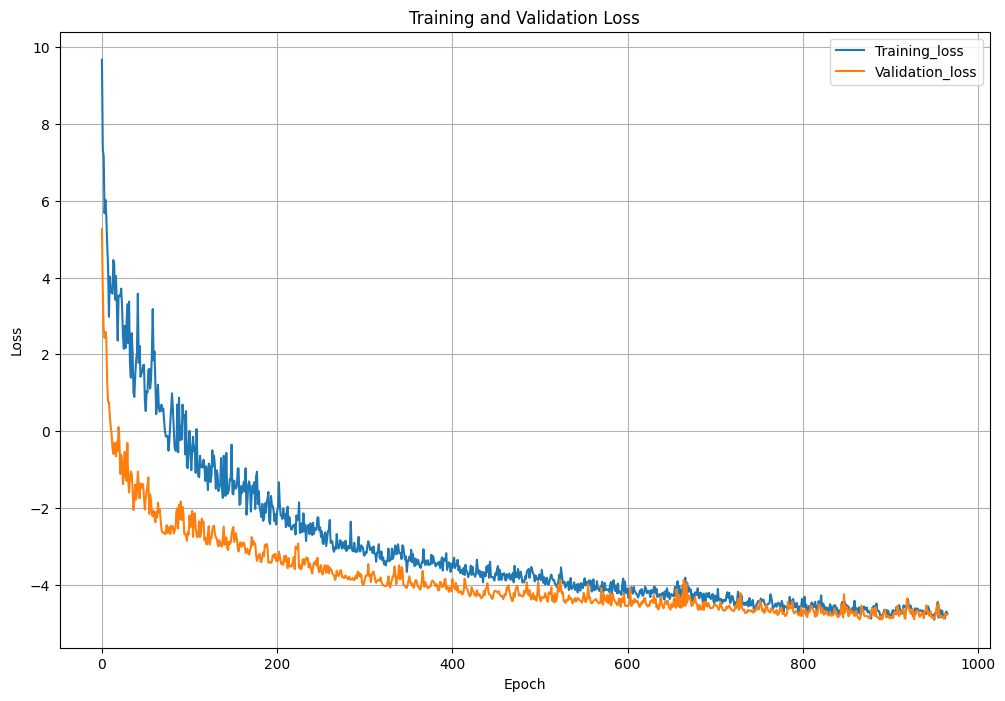

In [29]:
# Loss Plot

plot_loss(df1_history)#, logy=True, ylim=[15, 25])

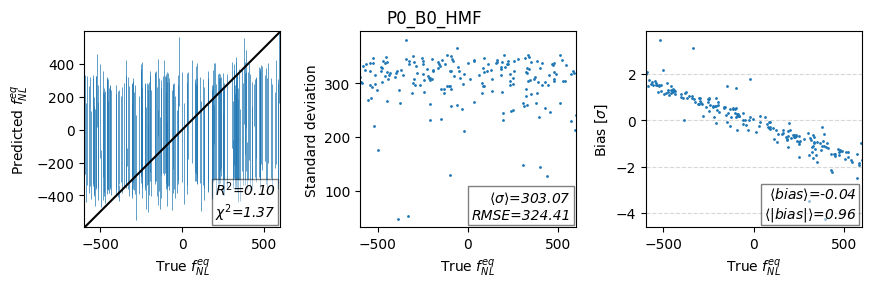

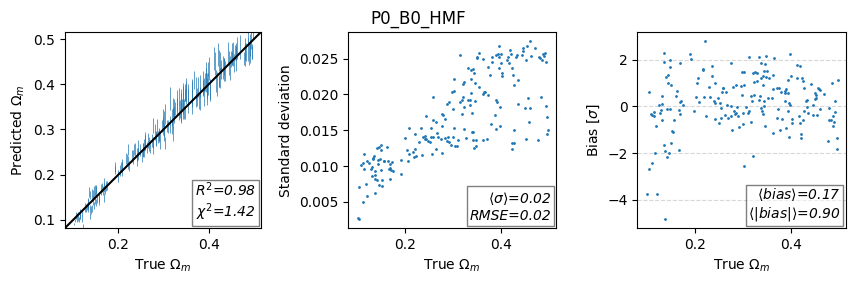

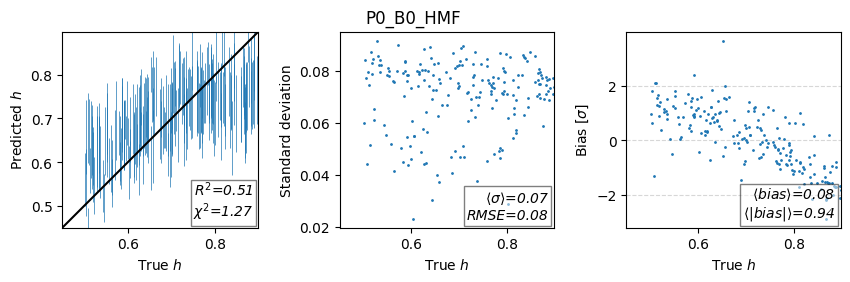

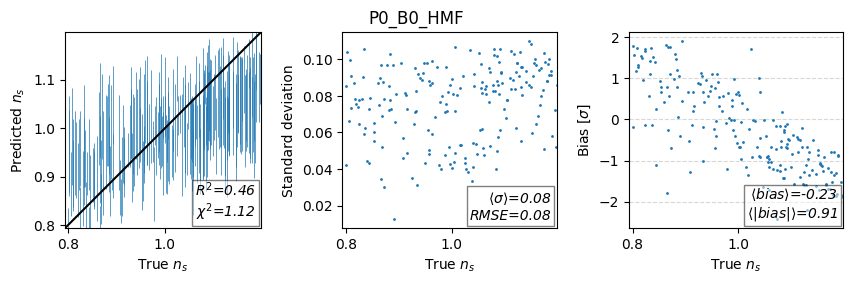

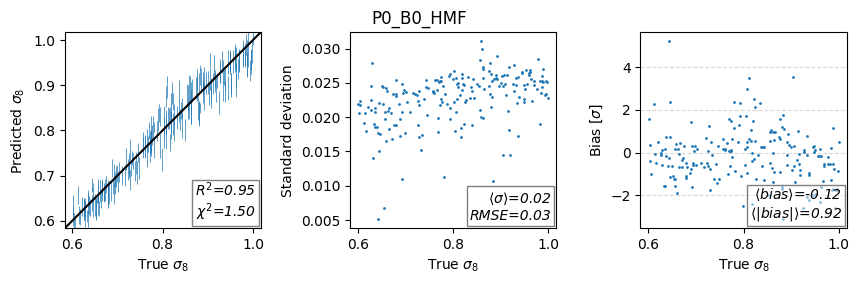

In [30]:
predictions1 = prediction(model1,X1_test,y1_test,mean_params,std_params,title = "P0_B0_HMF")


### Power Spectrum and Bispectrum Only

In [31]:
# Call the Data
columns = [P0, B0]
df_2 = input_data(columns,norm_lbl)


In [32]:
X2_train, X2_val, X2_test, y2_train, y2_val, y2_test = train_val_test_split(df_2)

In [33]:
X_training_set = X2_train
tuner2 = kt.BayesianOptimization(
    model_build,
    objective= 'val_loss',
    max_trials = 20,
    directory='keras_tuner_dir',
    project_name='BO_P0B0_1')
# Running the HyperParameter Search

tuner2.search(X2_train, y2_train, validation_data=(X2_val, y2_val), epochs=100000, callbacks=callback())




Reloading Tuner from keras_tuner_dir/BO_P0B0_1/tuner0.json


In [34]:
best_hp2=tuner2.get_best_hyperparameters(num_trials=1)[0]

best_num_layers = best_hp2.get('num_layers')
best_architecture = [best_hp2.get(f"unit_num_{i}") for i in range(best_num_layers)]
best_learning_rate = best_hp2.get('learning_rate')
best_dropout_rate = best_hp2.get('dropout_rate')

print(f"""
Best Hyperparameters:
- Number of Layers: {best_num_layers}
- Architecture: {best_architecture}
- Learning Rate: {best_learning_rate}
- Dropout Rate: {best_dropout_rate}
""")
print(tuner2.search_space_summary())
print(tuner2.results_summary())


Best Hyperparameters:
- Number of Layers: 5
- Architecture: [352, 32, 64, 192, 416]
- Learning Rate: 0.001
- Dropout Rate: 0.1

Search space summary
Default search space size: 8
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
unit_num_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
dropout_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
unit_num_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
unit_num_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
unit_num_3 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, '

In [35]:
# Fitting the model
model2 = model_build(best_hp1)
histories2= model2.fit(
    X2_train,
    y2_train,
    validation_data=(X2_val,
                     y2_val),
    batch_size=512,
    epochs=1000000,
    callbacks=callback(),
    verbose=0,
)
# Histories return 
df2_history = pd.DataFrame(histories2.history)
df2_history

,loss,val_loss
0,7.896173,3.438272
1,6.476676,2.352515
2,5.779790,1.109448
3,5.962471,1.825622
4,4.323188,1.898659
...,...,...
1500,-3.593970,-3.368375
1501,-3.558800,-3.317216
1502,-3.489047,-3.321738
1503,-3.598826,-3.435451


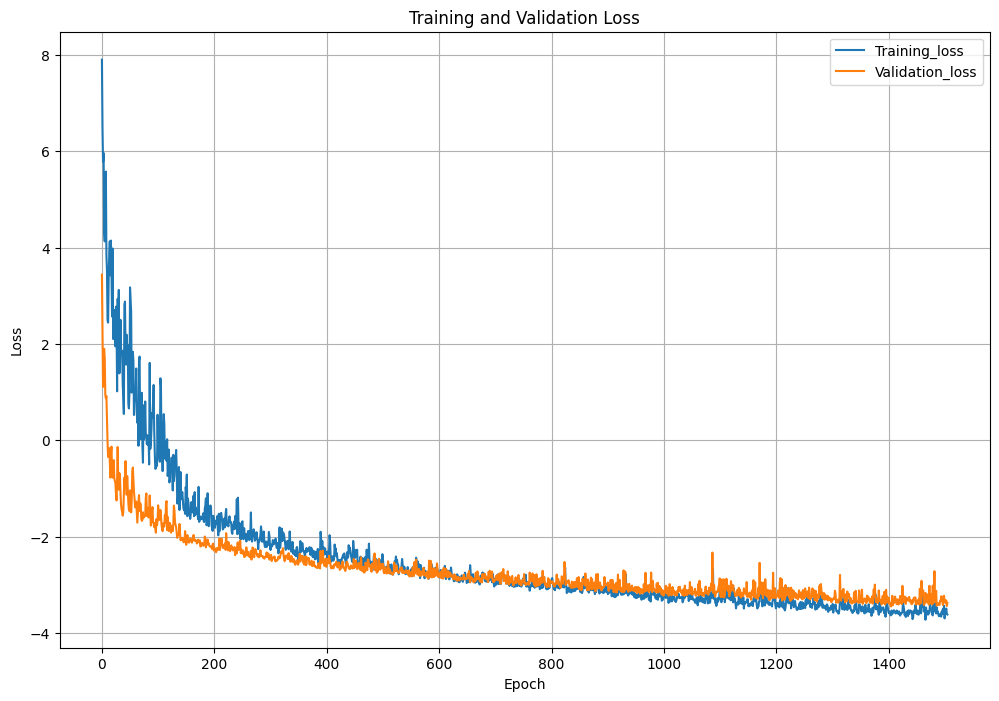

In [36]:
# Loss Plot
plot_loss(df2_history)#, logy=True, ylim=[15, 25])

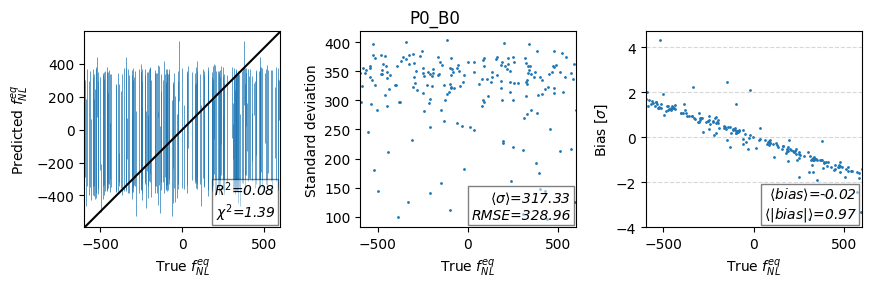

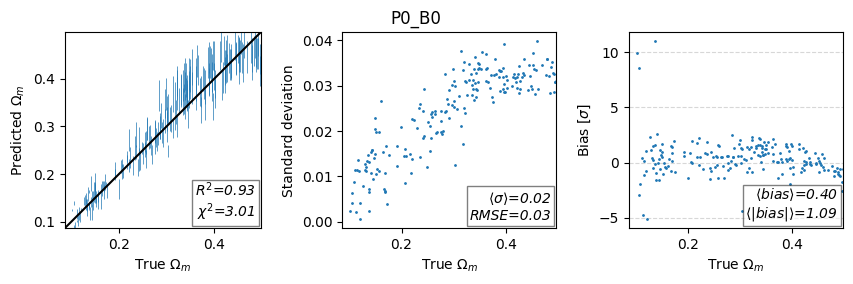

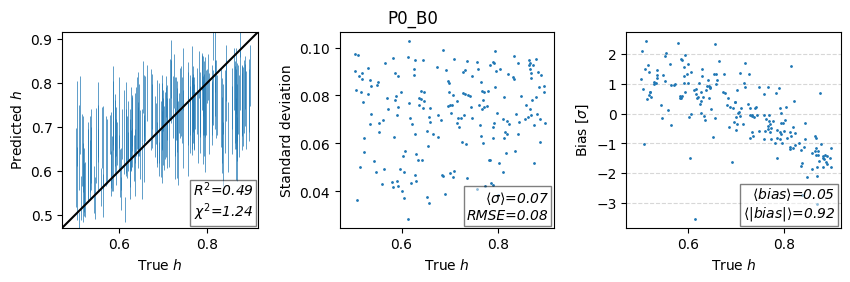

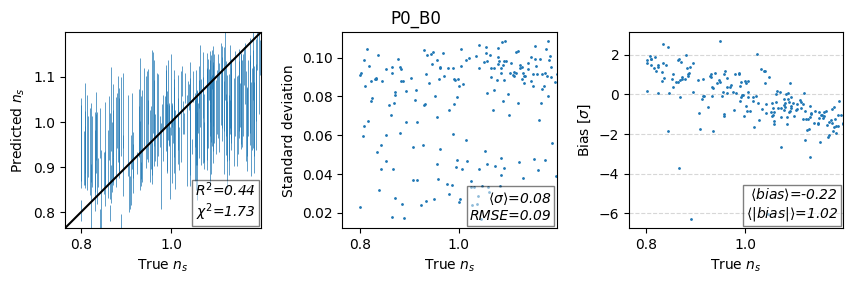

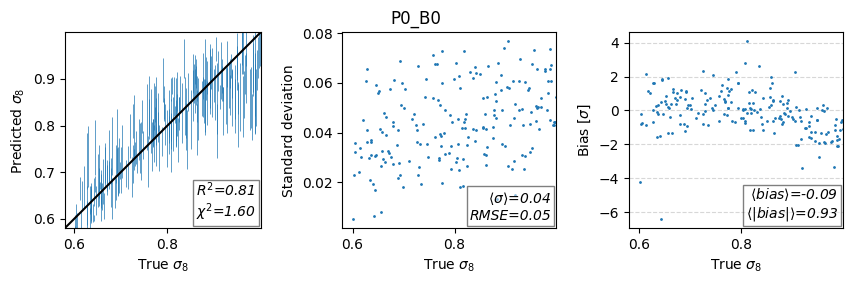

In [37]:
predictions2 = prediction(model2,X2_test,y2_test,mean_params,std_params,title = "P0_B0")
